The following illustration shows a generic base neural network model, Mp (Machine Learning model/ML-Model) trained on ImageNet dataset (Da). The base model is then used as the base for Transfer Learning, on Image Classification task (based on resnet18). The last layer of this pre-trained model (fully-connected/fc layer, A2) is then modified (to be A2') by a quantum means through a quantum machine learning framework: Pennylane.ai with a new dataset (Db), generating a new model (Mrt).

The Quantum ML framework (which is open-source) provides convenient access to multiple quantum simulator and real quantum computer backend, including IBM real Quantum Computer on IBM Quantum Computing Experience (IBM Cloud) through an open-source Qiskit API (Application Programming Interface) accessible by Python programming language.

It is recommended to run this project on Google Colab, utilizing the GPU accelerator. 


# 1. Preparation

## Load required Python libraries

In [49]:
!pip3 install -q cirq
!pip3 install -q torch
!pip3 install -q qiskit
!pip3 install -q pennylane
!pip3 install -q matplotlib
!pip3 install -q torchvision
!pip3 install -q prettytable
!pip3 install -q pennylane-cirq
!pip3 install -q pennylane-qiskit

# System
import time
import os, platform, sys
import copy
from datetime import datetime

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np
from pennylane_qiskit import AerDevice

# Plotting
import matplotlib.pyplot as plt

# Quantum computers/simulators
import qiskit
import cirq
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
from cirq import Simulator

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.

In [50]:
print("[Python version]:", sys.version)
print("[Deep Learning framework, Pytorch (Facebook) version]:", torch.__version__)
print("[Qiskit (IBM) version]:", qiskit.__version__)
print("[Quantum Machine Learning framework (Pennylane) version]:", qml.__version__)

[Python version]: 3.9.10 (main, Jan 15 2022, 11:40:53) 
[Clang 13.0.0 (clang-1300.0.29.3)]
[Deep Learning framework, Pytorch (Facebook) version]: 1.10.1
[Qiskit (IBM) version]: 0.19.1
[Quantum Machine Learning framework (Pennylane) version]: 0.20.0


## Create & Save IBM Token Credential to local computer

In [51]:
IBMQ.save_account('a63b6a1cf53003aefe2ae45e4c33c98cf203d4e30fe96cdb091d38a8f81145e22c207f3bacd65d90d9dd3e85022f0cace70d2aa471b555124450d14296f897b1', overwrite=True) 

Hardware:
- CPU Configuration: Laptop CPU, MBP M1 with 16gb ram  
- GPU Configuration: GColab Server with NVidia V100 16GB GPU (usually)

#### Dataset for face mask & no mask (about 1500 images for training and validation, in _data/faces directory)

face mask/no_mask dataset - https://github.com/prajnasb/observations/tree/master/experiements/data

- 2 categories, each category about 750 for images training & validation
- Just for a quick go-through, set num_epochs = 1. ==> Training Accuracy will be about 93%
- around 45 min per epoch on CPU, batch size=8

If all things looks ok, num_epochs = 10 will produce quite a good result, but longer time to train on CPU 
- around 7 hours for 30 epochs on CPU, batch size=8
- if high-end gpu is available, this should be just about 2 hours


## Set Parameters

In [52]:
dataset_dir = "chest_xray"

num_epochs = 16                     # Number of training epochs (1 for testing, 16 for final)
n_qubits = 5                        # Number of qubits 
step = 0.0004                       # Learning rate
batch_size = 8                      # Number of samples for each training step
q_depth = 6                         # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1            # Learning rate reduction applied every 10 epochs.
q_delta = 0.01                      # Initial spread of random quantum weights
rng_seed = 3                        # Seed for random number generator
start_time = time.time()            # Start of the computation timer

model_fileext = ".pth"
log_fileext = ".log" 

## Define Backend: Quantum Simulator or real Quantum Computer

In [53]:
def select_qc_backend():
    valid_selections = ('1', '2', '3', '5', '9')
    prompt = "Please select source:\n \
        1: Pennylane.ai Quantum Simulator\n \
        2: Qiskit Aer, IBM Quantum Simulator (local)\n \
        3: Qiskit IBMQ:Aer, IBM Quantum Simulator (IBM Quantum Computing Experience)\n \
        5: Google Cirq:Simulator (local)\n \
        9: Qiskit IBMQ:Terra, IBM real Quantum Computer (IBM Quantum Computing Experience)\n"    
    selection = input(prompt)
    while not(selection in valid_selections):
        selection = input(prompt)
    return selection

# select backend quantum computer
qc_backend = int(select_qc_backend())
if qc_backend == 1: # pennylane
    backend_name = "simPennylane"
    print("=> Using Pennylane Quantum Computer Simulator (local)")
    dev = qml.device("default.qubit", wires=n_qubits)
elif qc_backend == 2: # ibm quantum simulator (local) 
    backend_name = "simIBMQLocal"
    print("=> Using IBM Quantum Computer Simulator (local)")
    dev = qml.device("qiskit.aer", wires=n_qubits)
elif qc_backend == 3: # ibm quantum simulator (cloud) 
    backend_name = "simIBMQCloud"
    print("=> Using IBM Quantum Computer Simulator (IBM Quantum Computing Experience on IBM Cloud)")
    print("Loading IBMQ credentials...")
    IBMQ.load_account()
    provider = IBMQ.get_provider('ibm-q')
    backend = 'ibmq_qasm_simulator'
    dev = qml.device("qiskit.ibmq", wires=n_qubits, backend=backend)
    #dev.capabilities()['backend']
elif qc_backend == 5: # google quantum simulator (local) 
    backend_name = "simGoogleLocal"
    print("=> Using Google Quantum Computer Simulator (local)")
    dev = qml.device("cirq.simulator", wires=n_qubits)
elif qc_backend == 9: # ibm real quantum computer (cloud)
    backend_name = "realIBMQCloud"
    print("=> Using real IBM Quantum Computer (IBM Quantum Computing Experience on IBM Cloud)")
    print("Loading IBMQ credentials...")
    IBMQ.load_account()
    provider = IBMQ.get_provider('ibm-q')
    print("Searching available least busy real IBM Quantum Computer...")
    backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 4 \
        and not x.configuration().simulator \
        and x.status().operational==True))
    print('using least busy backend:', backend)
    dev = qml.device("qiskit.ibmq", wires=n_qubits, backend=str(backend))
    #dev.capabilities()['backend']


=> Using real IBM Quantum Computer (IBM Quantum Computing Experience on IBM Cloud)
Loading IBMQ credentials...


ibmqfactory.load_account:WARNING:2022-01-20 23:05:59,118: Credentials are already in use. The existing account in the session will be replaced.


Searching available least busy real IBM Quantum Computer...
using least busy backend: ibmq_belem


def select_qc_backend():
    valid_selections = ('1', '2', '3', '4', '5')
    prompt = "Please select source:\n \
        1: Pennylane.ai Quantum Simulator\n \
        2: Qiskit Aer, IBM Quantum Simulator (local)\n \
        3: Qiskit Aer, IBM Quantum Simulator (IBM Quantum Computing Experience)\n \
        4: Qiskit IBMQ, IBM real Quantum Computer (IBM Quantum Computing Experience)\n \
        5: Google Cirq:Simulator (local)\n"    
    selection = input(prompt)
    while not(selection in valid_selections):
        selection = input(prompt)
    return selection

# select backend quantum computer
qc_backend = int(select_qc_backend())
if qc_backend == 1: # pennylane
    backend_name = "simPennylane"
    print("=> Using Pennylane Quantum Computer Simulator (local)")
    dev = qml.device("default.qubit", wires=n_qubits)
elif qc_backend == 2: # ibm quantum simulator (local) 
    backend_name = "simIBMQLocal"
    print("=> Using IBM Quantum Computer Simulator (local)")
    dev = qml.device("qiskit.aer", wires=n_qubits)
elif qc_backend == 3: # ibm quantum simulator (cloud) 
    backend_name = "simIBMQCloud"
    print("=> Using IBM Quantum Computer Simulator (IBM Quantum Computing Experience on IBM Cloud)")
    print("Loading IBMQ credentials...")
    IBMQ.load_account()
    provider = IBMQ.get_provider('ibm-q')
    backend = 'ibmq_qasm_simulator'
    dev = qml.device("qiskit.ibmq", wires=n_qubits, backend=backend)
    #dev.capabilities()['backend']
elif qc_backend == 4: # ibm real quantum computer (cloud)
    backend_name = "realibmqcloud"
    print("=> using real ibm quantum computer (ibm quantum computing experience on ibm cloud)")
    print("loading ibmq credentials...")
    ibmq.load_account()
    provider = IBMQ.get_provider('ibm-q')
    print("searching available least busy real ibm quantum computer...")
    backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 4 \
        and not x.configuration().simulator \
        and x.status().operational==true))
    print('using least busy backend:', backend)
    dev = qml.device("qiskit.ibmq", wires=n_qubits, backend=str(backend))
    #dev.capabilities()['backend']
elif qc_backend == 5: # google quantum simulator (local) 
    backend_name = "simGoogleLocal"
    print("=> Using Google Quantum Computer Simulator (local)")
    dev = qml.device("cirq.simulator", wires=n_qubits)


In [54]:
now = datetime.now()
now_str = now.strftime("%d%m%Y%H%M%S")

# model & log file name to generate
# swgCQ_resnet18_ + selected backend name + max epochs + current date & time + extension
#   - pytorch model file extension '.pth'
#   - log file for the generated model file extension '.log'
base_filename = "swgCQ_"
interim_model_name = base_filename + backend_name 
hybrid_model_name = base_filename + backend_name + "(" + str(num_epochs) + ")-" + now_str + model_fileext
log_filename = base_filename + backend_name + "(" + str(num_epochs) + ")-" + now_str + log_fileext

train_val_filename = base_filename + backend_name + "_train_val-results" + now_str

In [55]:
# USE NVidia CUDA (GPU) if available
# ----------------------------------
is_cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if is_cuda_available else "cpu")
if is_cuda_available:
    print ("cuda is available, using:", device)
else:
    print ("cuda is not available, using:", device)

cuda is not available, using: cpu


## Prepare new dataset to retrain last layer (fc-layer) of pre-trained resnet-18

In [56]:
# initialize data loaders
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = dataset_dir # Images data, faces with and without mask
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

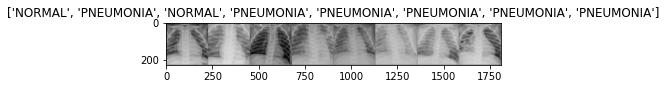

In [57]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# In order to get reproducible results, we set a manual seed for the
# random number generator and re-initialize the dataloaders.

torch.manual_seed(rng_seed)
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

## Define quantum layer to replace the fc-layer of pre-trained resnet-18

### Variational Quantum Circuit

#### Define base quantum layers
Define quantum layers that will compose the quantum circuit
- Hadamard (for making superposition)
- Ry & Entanglement

In [58]:
# 1st - Prepare the Quantum Gates
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
        
def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)
        
def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

#### Define Quantum Circuit
Define the quantum circuit through the PennyLane qnode decorator. The structure is that of a typical variational quantum circuit:
- Embedding layer: All qubits are first initialized in a balanced superposition of up and down states, then they are rotated according to the input parameters (local embedding).
- Variational layers: A sequence of trainable rotation layers and constant entangling layers is applied.
- Measurement layer: For each qubit, the local expectation value of the 
Z operator is measured. This produces a classical output vector, suitable for additional post-processing.

In [59]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """
    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)
    
    # Embed features in the quantum node
    RY_layer(q_input_features)
    
    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])
        
    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

#### Define a custom torch.nn.Module representing a dressed quantum circuit.

This is a concatenation of:
- A classical pre-processing layer (nn.Linear)
- A classical activation function (torch.tanh)
- A constant np.pi/2.0 scaling
- The previously defined quantum circuit (quantum_net)
- A classical post-processing layer (nn.Linear)

The input of the module is a batch of vectors with 512 real parameters (features) and the output is a batch of vectors with two real outputs (associated with the two classes of images: face_mask and face_nomask).

In [60]:
# 2nd - Prepare the Replacement Quantum Layer
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

#### Build a full hybrid classical-quantum network

Following the transfer learning approach:

- load the classical pre-trained network ResNet18 from the torchvision.models zoo
- freeze all the weights since they should not be trained
- replace the last fully connected layer with our trainable dressed quantum circuit (DressedQuantumNet)

In [61]:
# 3rd - Replace last layer of resnet-18 with defined quantum layer
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False

# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler)

# 2. Retrain

## Define how to retrain the DressedQuantumNet (last layer)

In [63]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, temp_model_name):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    
    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                message = "     > Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                                    phase,
                                    epoch + 1,
                                    num_epochs,
                                    it + 1,
                                    n_batches + 1,
                                    time.time() - since_batch,
                                 )
                # Print to screen with flush=True 
                print(message,
                        end="\r",
                        flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            message = "     > Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}".format(
                                "train" if phase == "train" else "validation  ",
                                epoch + 1,
                                num_epochs,
                                epoch_loss,
                                epoch_acc,
                            )

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            train_Acc = "{:.4f}".format(best_acc_train)
            train_Loss = "{:.4f}".format(best_loss_train)
            val_Acc = "{:.4f}".format(best_acc)
            val_Loss = "{:.4f}".format(best_loss)
            
            # Update learning rate
            if phase == "train":
                scheduler.step()
        
        # save the retrained model at this epoch completion
        # epoch is saved as epoch+1 (so to start at 1 instead of 0)
        # ---------------------------------------------------------
        model_at_epoch = temp_model_name + "-at-epoch-"+ str(epoch+1) \
            + "(" + str(num_epochs) + ")-" + now_str + model_fileext
        torch.save(model_hybrid.state_dict(), model_at_epoch)
        
        # save results of trained model at this epoch
        # ------------------------------------------- 
        # append list of "epoch, train accuracy, train loss, val accuracy, val loss" per epoch completion
        #   accumulate in train_val_results
        if epoch==0:
            # create first row
            train_val_results = np.array([[epoch+1, best_acc_train, best_loss_train, best_acc, best_loss]])
        else:
            train_result_at_epoch = np.array([[epoch+1, best_acc_train, best_loss_train, best_acc, best_loss]])
            # append new row
            train_val_results = np.append(train_val_results, train_result_at_epoch, axis=0) 
        
    # Write train_val_results to file
    np.save(train_val_filename, train_val_results)
    
    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    total_training_time = "{:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    total_training_time = "{:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    return model, total_training_time, train_Acc, train_Loss, val_Acc, val_Loss, train_val_results

## Re-train the quantum layer

In [64]:
model_hybrid, total_training_time, train_Acc, train_Loss, val_Acc, val_Loss, train_val_results = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs, temp_model_name = interim_model_name)

In [ ]:
# SAVE final retrained Resnet-18 model
# ------------------------------------
torch.save(model_hybrid.state_dict(), hybrid_model_name)

In [ ]:
# PRINT training summary
# ----------------------
from prettytable import PrettyTable
    
t_summary = PrettyTable()
t_summary.field_names = ["QC backend", "epoch", "batch size", \
    "train time", "train Acc", "train Loss", "val Acc", "val Loss"]
t_summary.add_row([backend_name, num_epochs, batch_size, \
    total_training_time, train_Acc, train_Loss, val_Acc, val_Loss])

In [ ]:
for x in train_val_results:
    print(x)

[1.         0.89378834 0.32788472 0.625      0.59707949]


In [ ]:
epoch = []
train_acc = []
train_loss = []
val_acc =[]
val_loss = []

for i in range(0, len(train_val_results)):
    epoch = np.append(epoch, train_val_results[i,0])
    train_acc = np.append(train_acc, train_val_results[i,1])
    train_loss = np.append(train_loss, train_val_results[i,2])    
    val_acc = np.append(val_acc, train_val_results[i,3])
    val_loss = np.append(val_loss, train_val_results[i,4])    

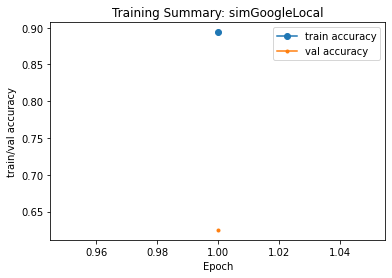

In [ ]:
# PLOT graph - training/validation accuracy, loss
# -----------------------------------------------
x1 = epoch
x2 = epoch
y1 = train_acc
y2 = val_acc

# plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Training Summary: ' + backend_name)
plt.ylabel('train/val accuracy')

# plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Epoch')
# plt.ylabel('train/val accuracy')

plt.legend(["train accuracy","val accuracy"])
plt.show()

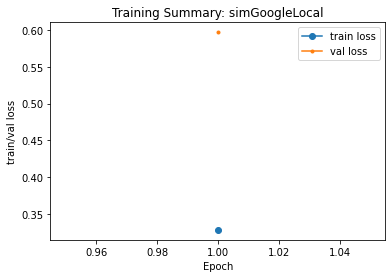

In [ ]:
# PLOT graph - training/validation accuracy, loss
# -----------------------------------------------
y1 = train_loss
y2 = val_loss

# plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Training Summary: ' + backend_name)
plt.ylabel('train/val loss')

# plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Epoch')
# plt.ylabel('train/val loss')

plt.legend(["train loss","val loss"])
plt.show()

In [ ]:
# INSPECT the retrained Resnet-18 model neural network architecture
# -----------------------------------------------------------------
model_arch = model_hybrid.eval()

# 3. Test/Predict using the re-trained model

In [ ]:
def visualize_model(model, num_images=4, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name, figsize=(15,15))
    model.eval()
    with torch.no_grad(): # inferencing
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            # Expectation value is probabilistic expected value of the result (measurement) of an experiment
            # Pennylane implements the quantum measurement in such a way that:
            #  - if the first qubit is non zero, it puts negative to the measurement
            # expvals is expectation value of predicted class
            expvals, preds = torch.max(outputs, 1)
            # expvals_min is expectation value of another class as we only have 2 image classes/categories here
            expvals_min, preds_min = torch.min(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                title = "Detected as <" + class_names[preds[j]] + ">, Expectation Value: " + \
                    "{:.5f}".format(expvals[j]) + " (" + \
                    "{:.5f}".format(expvals_min[j]) + ")" 
                ax.set_title("[{}]".format(title))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

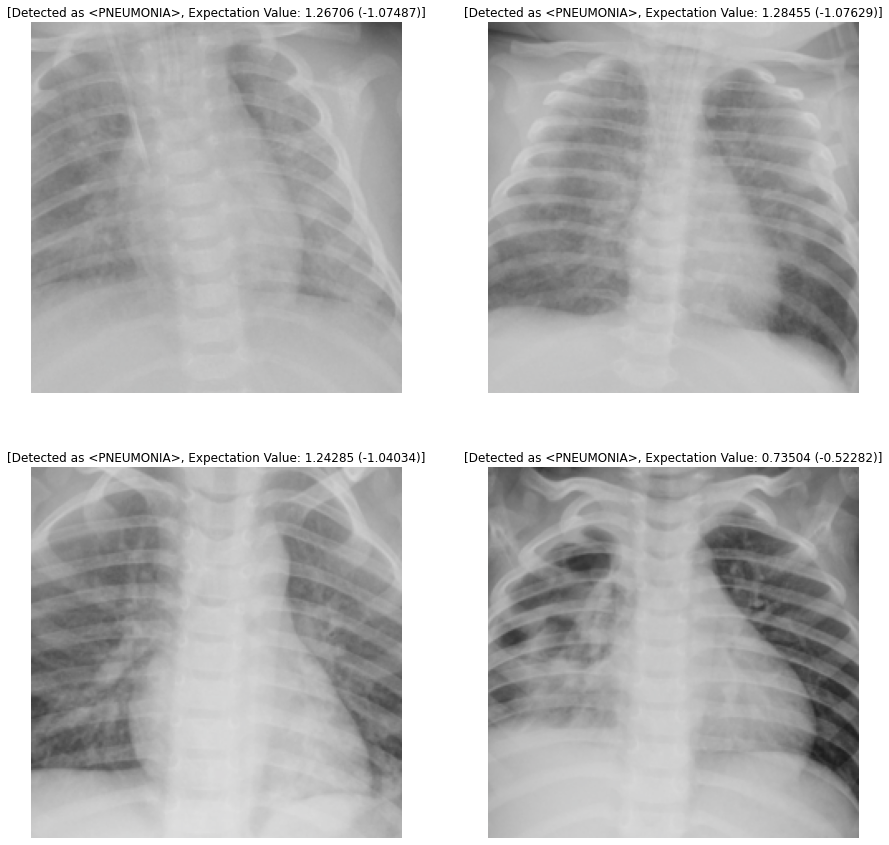

In [ ]:
visualize_model(model_hybrid, num_images=4, fig_name="Predictions")
plt.show()